# The Project #
1. This is a project with minimal scaffolding. Expect to use the the discussion forums to gain insights! It’s not cheating to ask others for opinions or perspectives!
2. Be inquisitive, try out new things.
3. Use the previous modules for insights into how to complete the functions! You'll have to combine Pillow, OpenCV, and Pytesseract
4. There are hints provided in Coursera, feel free to explore the hints if needed. Each hint provide progressively more details on how to solve the issue. This project is intended to be comprehensive and difficult if you do it without the hints.

### The Assignment ###
Take a [ZIP file](https://en.wikipedia.org/wiki/Zip_(file_format)) of images and process them, using a [library built into python](https://docs.python.org/3/library/zipfile.html) that you need to learn how to use. A ZIP file takes several different files and compresses them, thus saving space, into one single file. The files in the ZIP file we provide are newspaper images (like you saw in week 3). Your task is to write python code which allows one to search through the images looking for the occurrences of keywords and faces. E.g. if you search for "pizza" it will return a contact sheet of all of the faces which were located on the newspaper page which mentions "pizza". This will test your ability to learn a new ([library](https://docs.python.org/3/library/zipfile.html)), your ability to use OpenCV to detect faces, your ability to use tesseract to do optical character recognition, and your ability to use PIL to composite images together into contact sheets.

Each page of the newspapers is saved as a single PNG image in a file called [images.zip](./readonly/images.zip). These newspapers are in english, and contain a variety of stories, advertisements and images. Note: This file is fairly large (~200 MB) and may take some time to work with, I would encourage you to use [small_img.zip](./readonly/small_img.zip) for testing.

Here's an example of the output expected. Using the [small_img.zip](./readonly/small_img.zip) file, if I search for the string "Christopher" I should see the following image:
![Christopher Search](./small_project.png)
If I were to use the [images.zip](./readonly/images.zip) file and search for "Mark" I should see the following image (note that there are times when there are no faces on a page, but a word is found!):
![Mark Search](./large_project.png)

Note: That big file can take some time to process - for me it took nearly ten minutes! Use the small one for testing.

**Author**: Shailendra Singh   
**Last Updated**: 20th May, 2020

***

### Import Statements

In [1]:
import zipfile
from os import path

from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import pytesseract
import cv2 as cv
import numpy as np
from math import ceil
print('Modules Loaded')
# loading the face detection classifier
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')

# the rest is up to you!
RES_FOLDER="./"
SMALL_ZIP_FILE_NAME='small_img.zip'
FULL_ZIP_FILE_NAME='images.zip'

Modules Loaded


In [2]:
# This is used to resolve TesseractNotFound Error on Windows
from sys import platform
if platform == "linux" or platform == "linux2":
    # linux
    pass
elif platform == "darwin":
    # OS X
    pass
elif platform == "win32":
    # Windows...
    pytesseract.pytesseract.tesseract_cmd =r'C:\Program Files\Tesseract-OCR\tesseract.exe' 
    # Or paste your executable location in above string.

### Helper Functions

In [3]:
# --- Helper Functions ---

def get_images_from_zip(zip_path):
    '''
    params : 
        zip_path: Absolute path of the location of zip file
    returns: 
        dict Accumulator Dictionary with Images as Numpy nd-array in in Grey Scale.
    '''
    print('Reading archive: {}'.format(zip_path))
    
    img_storage={}
    img_zip=zipfile.ZipFile(img_zip_pth)
    
    for name in img_zip.namelist():
        if name[-3:].lower() in ('png', 'jpg', 'gif'):
            print('Found {}'.format(name), end='')
            item_file_obj = img_zip.open(name)
            # Add to the storage
            
            img_bytes = item_file_obj.read()
            npimg = np.fromstring(img_bytes, np.uint8)
            img_decoded = cv.imdecode(npimg, cv.IMREAD_COLOR)
            # Convert to Grey Scale and store as (numpy.ndarray, object)
            img_nd_array = cv.cvtColor(img_decoded, cv.COLOR_BGR2GRAY)
            
            img_storage[name]=img_nd_array
            print(' | Creating Numpy nd-array')
    
    return img_storage   


def crop_image(img, bounding_box):
    '''
    params:
        img: PIL Image
        bounding_box: expects a list -> [x, y, x+width, y+height], where
            x: start x-coordinate
            y: start y-coordinate
            width: width of box
            height: height of box
    returns:
        PIL Image
    '''
    cropped = img.crop(bounding_box)
    return cropped


def has_box_enclosed(outer_box, inner_box):
    '''
    params: each param expects a list of four int elements: a bounding box
        outer_box: [x,y,w,h]
        inner_box: [x,y,w,h] 
    returns: bool
        is inner_box present in outer_box
    '''
    x1, y1, w1, h1, = tuple(outer_box)
    x2, y2, w2, h2, = tuple(inner_box)
    return x2 >= x1 and w2 <= w1 and y2 >= y1 and h2 <= h1


def has_any_boxes_enclosed(outer_box, inner_box_list):
    '''
    params: 
        outer_box: [x,y,w,h] -> The outer box expects a list of bounding co-ordinates
        inner_box_list:list([x1,y1,w1,h1], [x2,y2,w2,h2] ... ) -> The inner box expects a list of boxes
    returns: bool
        if any item in inner box is found enclosed within outer box: return True , else False
    '''
    search_results = [has_box_enclosed(outer_box, inner_box)
                      for inner_box in inner_box_list]
    return True in search_results


### Create Custom Data Structure to store Images and their different forms
##### Storage Dictionary

In [4]:
# Dictionary to store Image's Numpy nd-array
img_ndarray_storage={}
# Dictionary to store Custom Image objects
img_storage={}

##### Model: CustomImage

In [5]:
class CustomImage():

    def __init__(self, img_name, img_nd_array):
        '''
        params:
            img_name: Name of Image File
            img_nd_array: Numpy nd array representing an Image
        '''
        self.name = img_name
        self.img_nd_array = img_nd_array

        self.pillow_img = None

        self.text_in_image = ""
        self.faces_in_image = []
        self.bounding_boxes = []

    def initialize(self):
        '''        
        Lazy implementation as this is a computation intensive initialization.
        Following actions are performed:
            * Detect Text in Image
            * Detect Faces in Image
            * Image Conversion
        '''
        print('{} initialization started.'.format(self))
        
        # Create Pillow Image
        self.pillow_img = Image.fromarray(self.img_nd_array)

        # Detect Text
        self.text_in_image = pytesseract.image_to_string(
            self.pillow_img).lower()
        self._keywords = set()
        # Cache keywords for first time
        if not self._keywords:
            import re
            import string
            # Clean text
            pattern = re.compile('[%s]' % re.escape(string.punctuation))
            _text = pattern.sub('', self.text_in_image)
            # Extract keywords
            for line in _text.split('\n'):
                for word in line.split():
                    _word = word.strip()
                    self._keywords.add(_word)

        # Detect Faces
        face_filter_ndarray = face_cascade.detectMultiScale(self.img_nd_array)
        face_filter_bounding_boxes = [
            list((x, y, x+w, y+h)) for x, y, w, h in face_filter_ndarray]
        # Improve upon false-positives by checking eyes in images too
        face_and_eye_filter_ndarray = eye_cascade.detectMultiScale(
            self.img_nd_array)
        face_and_eye_filter_bounding_boxes = [
            list((x, y, x+w, y+h)) for x, y, w, h in face_and_eye_filter_ndarray]

        # Predict face location by creating bounding box around it
        for box in face_filter_bounding_boxes:
            has_eyes = has_any_boxes_enclosed(
                box, face_and_eye_filter_bounding_boxes)
            if has_eyes:
                nd_array_box = np.array(box)
                self.bounding_boxes.append(nd_array_box)

        print('{} initialization completed.'.format(self))

    def is_keyword_present(self, keyword):
        '''
        params:
            keyword (str): Keyword to be searched in image
        returns:
            True or False

        (Optimized Search Performance)
        '''
        # Check membership in keyword set
        _keyword = keyword.lower()
        _keyword = _keyword.strip()
        return _keyword in self._keywords

    def get_face_thumbnails(self):
        '''
        return: list of PIL Images
            All possible faces in self Image
        '''
        face_images = []
        for box in self.bounding_boxes:
            _face_img = crop_image(self.pillow_img, box.tolist())
            face_images.append(_face_img)

        return face_images

    def show_thumbnail(self, basewidth=600):
        img = self.pillow_img
        wpercent = (basewidth / float(img.size[0]))
        hsize = int((float(img.size[1]) * float(wpercent)))
        thumbnail_img = img.resize((basewidth, hsize), Image.ANTIALIAS)
        display(thumbnail_img)

    def display(self):
        '''
        Displays PIL Image using display() function
        returns:
            None
        '''
        display(self.pillow_img)

    def __str__(self):
        return 'CustomImage ({})'.format(self.name)


##### Model: GridView

In [6]:
class GridView():
    def __init__(self, num_cols, grid_width):
        '''         
        params:
            num_cols: int <- number of columns in grid
            grid_width: int <-  grid width, will be used same for height to create square grid elements
        '''
        self.cols = num_cols
        self.width = grid_width
        self.height = self.width

    def resize_to_grid_cell(self, img):
        '''         
        params:
            img: PIL Image
        returns:
            Resized Image
        '''
        return img.resize((self.width, self.height), Image.ANTIALIAS)

    def draw_grid(self, img_list, label_text="", font_size=25):  
        '''
        params:
            img_list: int <- List of PIL Images
        '''
        text_font=ImageFont.truetype(font='fanwood-webfont.ttf', size=font_size)
        count = len(img_list)
        rows = ceil(count/self.cols)
        
        image_mode = 'L'
        
        # Set canvas parameters
        label_canvas_height = (self.height//2) # a third of image's height
        canvas_width = self.cols*self.width
        canvas_height = rows*self.height + label_canvas_height
        
        # Create Canvas
        canvas = Image.new(image_mode, (canvas_width, canvas_height))
        label_canvas = Image.new(image_mode, (canvas_width, label_canvas_height), color=255)
        draw = ImageDraw.Draw(canvas)  
        
        # Paste label in the first row
        canvas.paste(label_canvas, (0,0)) 
        y=label_canvas_height//3  
        draw.text((0, int(y)), label_text, font=text_font)
        
        # Fill up the grid
        x=0
        y=label_canvas_height
        for _img in img_list:
            img=self.resize_to_grid_cell(_img)
            canvas.paste(img, (x, y) )
            # Now we update our X position. If it is going to be the width of the image, then we set it to 0
            # and update Y as well to point to the next "line" of the contact sheet.
            if x+self.width == canvas.width:
                x=0
                y=y+self.height
            else:
                x=x+self.width

        # Display whole canvas
        display(canvas)

### Get Images from Zip archive

##### Save storage to global variable

In [7]:
# Create storage for Custom Image objects
img_zip_pth=path.join(RES_FOLDER, FULL_ZIP_FILE_NAME)
img_ndarray_storage = get_images_from_zip(img_zip_pth)
print('Loaded Images as Numpy nd-array')

Reading archive: ./images.zip
Found a-0.png

/home/elliot/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


 | Creating Numpy nd-array
Found a-1.png | Creating Numpy nd-array
Found a-10.png | Creating Numpy nd-array
Found a-11.png | Creating Numpy nd-array
Found a-12.png | Creating Numpy nd-array
Found a-13.png | Creating Numpy nd-array
Found a-2.png | Creating Numpy nd-array
Found a-3.png | Creating Numpy nd-array
Found a-4.png | Creating Numpy nd-array
Found a-5.png | Creating Numpy nd-array
Found a-6.png | Creating Numpy nd-array
Found a-7.png | Creating Numpy nd-array
Found a-8.png | Creating Numpy nd-array
Found a-9.png | Creating Numpy nd-array
Loaded Images as Numpy nd-array


##### Create CustomImage objects

In [8]:
img_storage={k:CustomImage(k,v) for k,v in img_ndarray_storage.items()}
print('CustomImage storage created.')

CustomImage storage created.


##### Initialize Image Storage

In [9]:
# Lazy instantiation
initializer = map(lambda f: f.initialize(), [img for img in img_storage.values()])

In [10]:
# list is used just to invoke the map object, the underlying f.initialize() will do the rest for each object.
temp=list(initializer)
print('Image Storage Initialized')

CustomImage (a-0.png) initialization started.
CustomImage (a-0.png) initialization completed.
CustomImage (a-1.png) initialization started.
CustomImage (a-1.png) initialization completed.
CustomImage (a-10.png) initialization started.
CustomImage (a-10.png) initialization completed.
CustomImage (a-11.png) initialization started.
CustomImage (a-11.png) initialization completed.
CustomImage (a-12.png) initialization started.
CustomImage (a-12.png) initialization completed.
CustomImage (a-13.png) initialization started.
CustomImage (a-13.png) initialization completed.
CustomImage (a-2.png) initialization started.
CustomImage (a-2.png) initialization completed.
CustomImage (a-3.png) initialization started.
CustomImage (a-3.png) initialization completed.
CustomImage (a-4.png) initialization started.
CustomImage (a-4.png) initialization completed.
CustomImage (a-5.png) initialization started.
CustomImage (a-5.png) initialization completed.
CustomImage (a-6.png) initialization started.
Custom

### Search Function and Results

In [11]:
def search_keyword_in_image_store(keyword):
    grid_view=GridView(5, 125)
    img_found_label='Results found in file {}'
    img_not_found_label='Results found in file {}.\nBut there were no faces in that file!'
    for img_name, img_obj in img_storage.items():
        is_keyword_present=img_obj.is_keyword_present(keyword)        
        thumbnails=img_obj.get_face_thumbnails()
        if not is_keyword_present:
            # Keyword Not found, then continue to next image
            continue
            
        # Has images
        if thumbnails:
            img_label=img_found_label.format(img_name)
            grid_view.draw_grid(thumbnails, img_label, 20)
        else:
            img_label=img_not_found_label.format(img_name)
            grid_view.draw_grid([], img_label, 20)           

#### Search for 'Christopher'

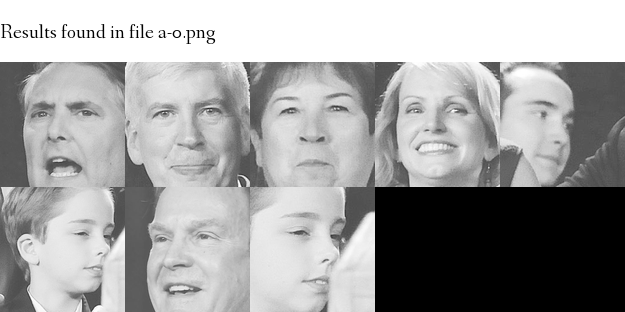

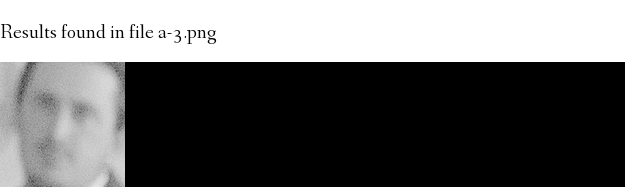

In [12]:
search_keyword_in_image_store('Christopher')

#### Search for 'Mark'

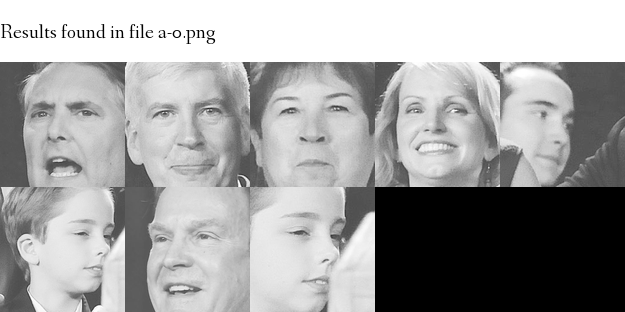

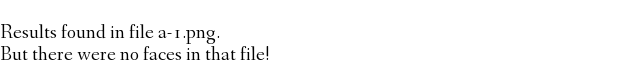

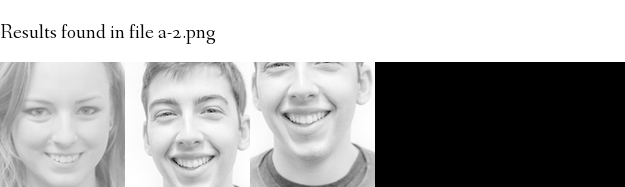

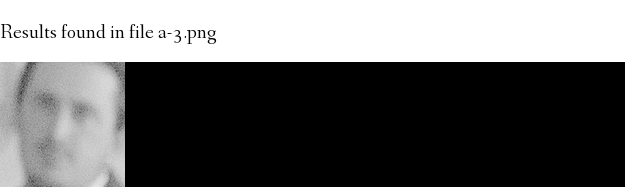

In [13]:
search_keyword_in_image_store('Mark')

### And some random searches

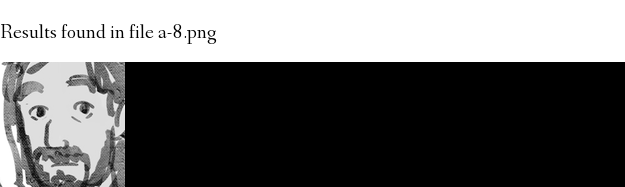

In [148]:
search_keyword_in_image_store('Jesus')

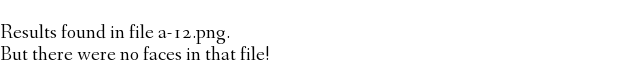

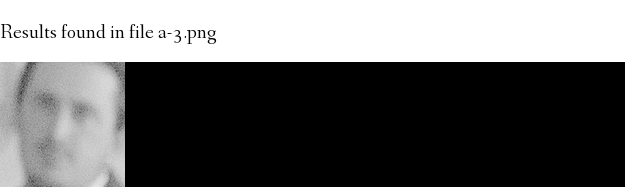

In [141]:
search_keyword_in_image_store('computer')

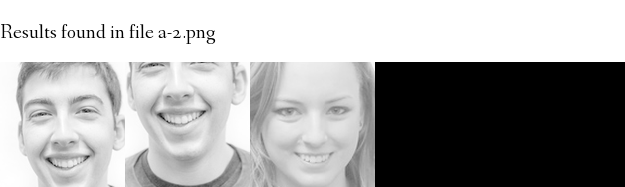

In [152]:
search_keyword_in_image_store('america')